Focus on the role of a solo mode

In [161]:
import requests
from lxml import etree
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import time
import sqlite3
import seaborn as sns
import statsmodels.formula.api as smf

In [138]:
sns.set(rc={'figure.figsize':(10,8)})

In [139]:
con = sqlite3.connect('bgg.db')
cur = con.cursor()

In [140]:
query = '''
 SELECT t1.id, CAST(t1.player_count AS INT64) player_count, t1.player_recommendation rec, CAST(t1.votes AS INT64) votes,
 SUM(CAST(votes AS INT64)) OVER (PARTITION BY t1.id) game_votes,
 SUM(CAST(votes AS INT64)) OVER (PARTITION BY t1.id, player_count) player_votes,
 CAST(t2.min_players AS INT64) min, CAST(t2.max_players AS INT64) max,
 
 -- column created for the sole purposes of ordering results
 CASE WHEN player_recommendation = 'Not Recommended' THEN 0
      WHEN player_recommendation = 'Recommended' THEN 1
      WHEN player_recommendation = 'Best' THEN 2
      ELSE NULL END order_col
 
 FROM BGG_PLAYER_RATINGS t1
     INNER JOIN TOP_GAMES_FULL t2
         ON t1.id = t2.id
 
 WHERE 1=1
     -- Remove the player counts that aren't possible, eg "5+"
     AND player_count NOT LIKE '%+%'
     AND CAST(t1.player_count AS INT64) >= t2.min_players
     AND CAST(t1.player_count AS INT64) <= t2.max_players
 
 ORDER BY t1.id ASC, player_count ASC, order_col ASC
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]
result_df = pd.DataFrame(result_li)
result_df.columns = ['id', 'players', 'rec', 'votes', 'game_votes', 'player_votes', 'min', 'max','temp']
result_df.drop('temp', axis = 1, inplace=True)

In [141]:
result_df['vote_percent'] = result_df['votes'] / result_df['player_votes']

In [142]:
# Checking query with Gloomhaven
result_df[result_df['id'] == '174430']

,id,players,rec,votes,game_votes,player_votes,min,max,vote_percent
3510,174430,1,Not Recommended,270,3927,916,1,4,0.294760
3511,174430,1,Recommended,521,3927,916,1,4,0.568777
3512,174430,1,Best,125,3927,916,1,4,0.136463
3513,174430,2,Not Recommended,67,3927,1024,1,4,0.065430
3514,174430,2,Recommended,671,3927,1024,1,4,0.655273
3515,174430,2,Best,286,3927,1024,1,4,0.279297
3516,174430,3,Not Recommended,30,3927,1011,1,4,0.029674
3517,174430,3,Recommended,401,3927,1011,1,4,0.396637
3518,174430,3,Best,580,3927,1011,1,4,0.573689
3519,174430,4,Not Recommended,137,3927,976,1,4,0.140369


In [143]:
# Testing to see if the math works
assert 270 + 521 + 125 == 916

In [144]:
# Checking a game with no official single player
result_df[result_df['id'] == '246192']

,id,players,rec,votes,game_votes,player_votes,min,max,vote_percent
7008,246192,2,Not Recommended,2,249,88,2,4,0.022727
7009,246192,2,Recommended,48,249,88,2,4,0.545455
7010,246192,2,Best,38,249,88,2,4,0.431818
7011,246192,3,Not Recommended,1,249,86,2,4,0.011628
7012,246192,3,Recommended,34,249,86,2,4,0.395349
7013,246192,3,Best,51,249,86,2,4,0.593023
7014,246192,4,Not Recommended,5,249,75,2,4,0.066667
7015,246192,4,Recommended,44,249,75,2,4,0.586667
7016,246192,4,Best,26,249,75,2,4,0.346667


In [145]:
result_df['player_votes'].min(), result_df['game_votes'].min()

(4, 9)

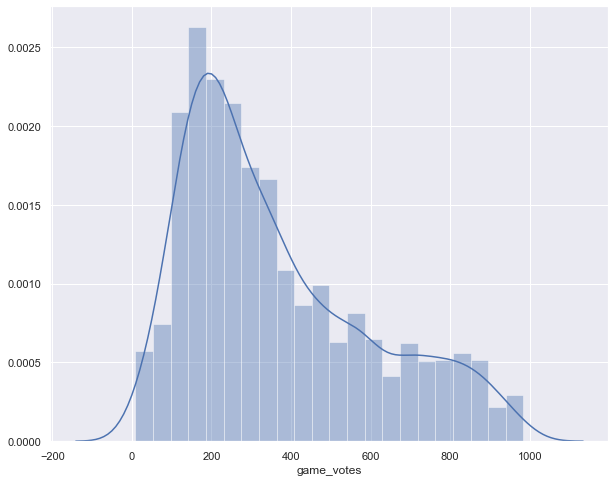

In [146]:
df_for_visual = result_df.drop_duplicates(subset =['id','players'])
df_for_visual = df_for_visual[df_for_visual['game_votes'] < 1000]
sns.distplot(df_for_visual['game_votes'])

Interesting to see some games with very few votes. Will probably have to remove them from the sample

In [147]:
# Get the percent of people who chose recommended or best for a given player count
recommending = result_df.loc[result_df['rec'] == 'Not Recommended', :]
recommending['percent_rec'] = 1 - recommending['vote_percent']
recommending.drop(['vote_percent', 'rec'], axis=1, inplace=True)

# Let's set a minimum of 100 total player count votes for the game
recommending = recommending.loc[recommending['game_votes'] >= 100, :]
print('New datasets contains {} unique games.'.format(recommending['id'].nunique()))

New datasets contains 883 unique games.


C:\Users\18053\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\18053\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [148]:
# Let's check games that offer a single player mode, but it gets poor results
recommending[recommending['players'] == 1].sort_values('percent_rec').head(5)

,id,players,votes,game_votes,player_votes,min,max,percent_rec
3789,179172,1,34,198,35,1,4,0.028571
4500,194607,1,53,142,55,1,2,0.036364
5409,21241,1,156,1047,181,1,4,0.138122
9483,4098,1,76,720,90,1,6,0.155556
10470,69789,1,96,634,118,1,4,0.186441


Some games may technically offer a solo mode, but they're bad enough that most players would ignore them

In [149]:
# How good are solo modes usually?
# Note, removing pure solo games
recommending.loc[(recommending['players'] == 1) & (recommending['max'] != 1), 'percent_rec'].median()

0.7670542635658915

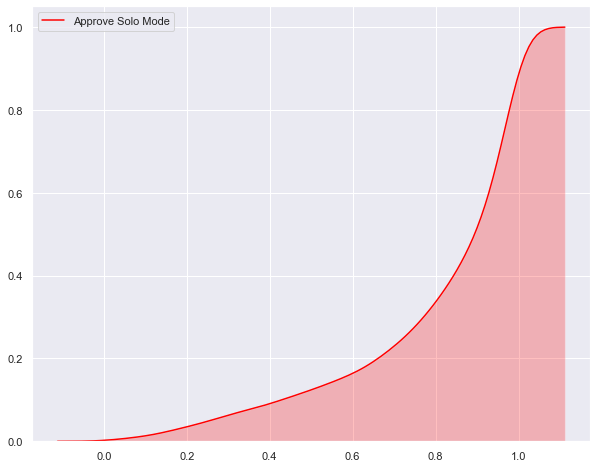

In [150]:
sns.kdeplot(recommending['percent_rec'], shade=1, color='red', label = 'Approve Solo Mode', cumulative=True)

In [151]:
sns.kdeplot?

Majority of these have at least 75% approval, so there are quite a few solid solo modes

Let's get a list of games with a solo mode

In [152]:
# I will rename the percent_rec column so it doesn't cause conflicts when joining

# Games with any solo mode
any_solo = recommending.loc[recommending['players'] == 1,['id', 'percent_rec']]
any_solo.columns = ['id', 'approved_percent_solo']

# Games with enough ratings
enough_ratings = recommending.loc[:, ['id', 'percent_rec']]
enough_ratings.drop_duplicates(subset='id',keep='first', inplace=True)
enough_ratings.columns = ['id', 'approved_percent_all']

Let's get the ratings and weight from the SQL tables

In [153]:
query = '''
 SELECT t1.id, CAST(t1.avg_rating AS FLOAT64) rating, CAST(t1.weight as FLOAT64) weight
 
 FROM TOP_GAMES_FULL t1
'''

results = cur.execute(query)
result_li = [elem for elem in results.fetchall()]
rating_df = pd.DataFrame(result_li, columns = ['id', 'score', 'weight'])

In [154]:
# Filter down to only the ones with enough player ratings

new_df = rating_df.merge(enough_ratings, how = 'inner', on = 'id')

# Check to make sure there's the right number of data points
assert new_df.shape[0] == 883

new_df.drop('approved_percent_all', axis=1,inplace=True)

In [155]:
new_df = new_df.merge(any_solo, on = ['id'], how = 'left')
new_df.loc[:, 'has_solo'] = np.where(new_df['approved_percent_solo'] > 0, 1, 0)
new_df.head()

,id,score,weight,approved_percent_solo,has_solo
0,174430,8.76798,3.8673,0.705240,1
1,161936,8.60479,2.8360,NaN,0
2,224517,8.66929,3.9084,NaN,0
3,167791,8.42470,3.2440,0.785266,1
4,291457,8.75730,3.5590,0.854251,1


Let's compare games with and without solo modes in two ways:

1. Games with any solo mode
2. Games with majority approved solo mode

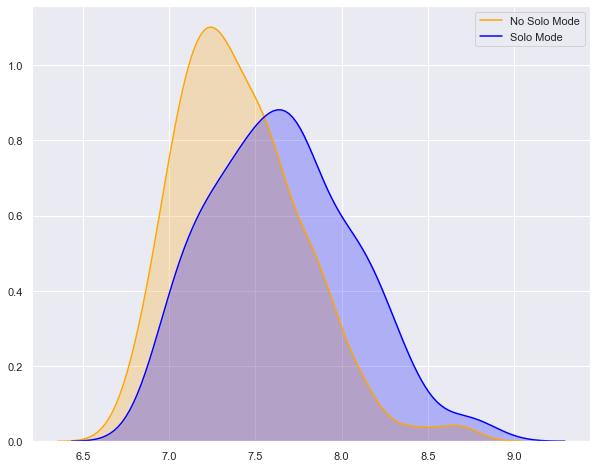

In [156]:
sns.kdeplot(new_df.loc[new_df['has_solo'] == 0, 'score'], shade=1, color='orange', label = 'No Solo Mode')
sns.kdeplot(new_df.loc[new_df['has_solo'] == 1, 'score'], shade=1, color='blue', label = 'Solo Mode')

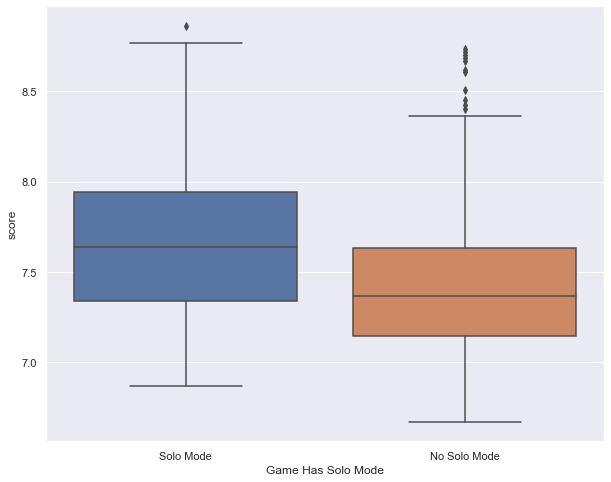

In [157]:
# Next column is just for seaborn purposes
new_df.loc[:, 'Game Has Solo Mode'] = np.where(new_df['has_solo'] == 1, 'Solo Mode', 'No Solo Mode')
sns.boxplot(data=new_df, y = 'score', x ='Game Has Solo Mode')

Now let's look at changing the label, so that only solo modes with >= 50% approval count as a solo mode

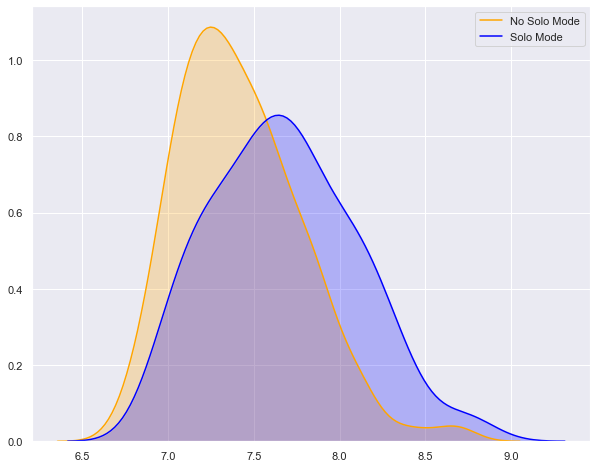

In [158]:
sns.kdeplot(new_df.loc[(new_df['has_solo'] == 0) | (new_df['approved_percent_solo'] < 0.5), 'score'], shade=1, color='orange', label = 'No Solo Mode')
sns.kdeplot(new_df.loc[new_df['approved_percent_solo'] >= 0.5, 'score'], shade=1, color='blue', label = 'Solo Mode')

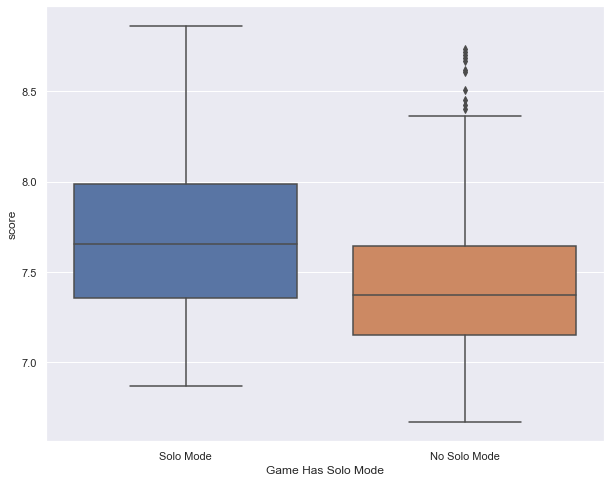

In [159]:
# Next column is just for seaborn purposes
new_df.loc[(new_df['approved_percent_solo'] < 0.5), 'Game Has Solo Mode'] = 'No Solo Mode'
sns.boxplot(data=new_df, y = 'score', x ='Game Has Solo Mode')

By either metrics, solo games score higher.

Now, let's run a regression controlling for a game's weight to see if it still matters

In [163]:
reg = smf.ols(data=new_df, formula='score~weight+has_solo').fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.323
Method:                 Least Squares   F-statistic:                     211.4
Date:                Sat, 25 Sep 2021   Prob (F-statistic):           1.07e-75
Time:                        20:12:04   Log-Likelihood:                -260.58
No. Observations:                 883   AIC:                             527.2
Df Residuals:                     880   BIC:                             541.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.7860      0.037    181.416      0.000       6.713       6.859
weight         0.2484      0.014     17.938      0.000       0.221       0.276
has_solo       0.1533      0.025      6.255      0.000       0.105       0.201
==============================================================================
Omnibus:                       58.407   Durbin-Watson:                   1.213
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.541
Skew:                           0.652   Prob(JB):                     1.31e-15
Kurtosis:                       3.405   Cond. No.                         10.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Controlling for weight, a game scores 0.15 points higher if it has solo mode.

Finally, one last model with an interaction term

In [165]:
reg = smf.ols(data=new_df, formula='score~weight*has_solo').fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.329
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     143.7
Date:                Sat, 25 Sep 2021   Prob (F-statistic):           9.49e-76
Time:                        20:18:13   Log-Likelihood:                -257.64
No. Observations:                 883   AIC:                             523.3
Df Residuals:                     879   BIC:                             542.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.8365      0.043    159.998      0.000       6.753       6.920
weight              0.2284      0.016     14.210      0.000       0.197       0.260
has_solo           -0.0591      0.091     -0.649      0.516      -0.238       0.120
weight:has_solo     0.0760      0.031      2.422      0.016       0.014       0.138
==============================================================================
Omnibus:                       60.387   Durbin-Watson:                   1.227
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               71.381
Skew:                           0.662   Prob(JB):                     3.16e-16
Kurtosis:                       3.435   Cond. No.                         28.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [168]:
p = reg.params
weight, solo, interaction = p['weight'], p['has_solo'], p['weight:has_solo']

Now, the solo coefficient is not statistically different from 0. That doesn't mean it's irrelevant, however, since the interaction term is positive. Weight is always positive, so solo games will always perform better. Since the solo coefficient has such a high p-value, I will ignore it in the following calculations. 

In [174]:
# I will calculate the effects of a solo mode for two different weights
# I know multiplying one doesn't impact the outcome, but it's there to show 
# a value of 1 for the has_solo variable

# Effect of solo gaming for a weight 2 game (like Azul)
print('Increase in score from a solo mode in weight 2 game')
print(np.round(2 * 1 * interaction,3))

# Effect of solo gaming for a weight 4 game (like A Feast for Odin)
print('Increase in score from a solo mode in weight 4 game')
print(np.round(4 * 1 * interaction,3))

Increase in score from a solo mode in weight 2 game
0.152
Increase in score from a solo mode in weight 4 game
0.304
